In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

# Sort structures

In [3]:
structures_sorted_by_size = ['4N', '6N', 'Amb', 'PBG', '10N', 'AP', '3N', 'LC', 'SNC', 'Tz', '7n', 'RMC', '5N', 'VCP', '12N', 'LRt', '7N', 'VCA', 'VLL', 'DC', 'Sp5O', 'Sp5I', 'Pn', 'RtTg', 'SNR', 'Sp5C', 'IC', 'SC']

x =[[s] if s in singular_structures else [convert_to_left_name(s), convert_to_right_name(s)] for s in structures_sorted_by_size]
structures_sided_sorted_by_size = [j for i in x for j in i ]
print structures_sided_sorted_by_size

['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']


# Load test dataset

In [4]:
detector_settings = read_csv(DETECTOR_SETTINGS_CSV, header=0, index_col=0)
detector_settings

,input_version,windowing_id,feature_network,feature_classifier_id,comments
detector_id,,,,,
1,gray,1,inception-bn-blue,38,NaN
2,grayL500H0,1,inception-bn-blue,38,NaN
3,grayL1000H0,1,inception-bn-blue,38,NaN
4,grayL1500H0,1,inception-bn-blue,38,NaN
5,grayL2000H0,1,inception-bn-blue,38,NaN
6,grayL2500H0,1,inception-bn-blue,38,NaN
7,grayL600H0,1,inception-bn-blue,38,NaN
8,grayL700H0,1,inception-bn-blue,38,NaN
9,grayL800H0,1,inception-bn-blue,38,NaN


In [5]:
classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)
classifier_settings

,model,margin_um,train_set_id,neg_composition,sample_weighting,input_img_version,svm_id,comment,num_samples_per_class
classifier_id,,,,,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN,cropped_gray,30,NaN,NaN
31,lr,500,21/22,neg_has_all_surround,NaN,cropped_gray,31,NaN,NaN
32,lr,500,20/22,neg_has_all_surround,NaN,cropped_gray,32,NaN,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN,cropped_gray,33,NaN,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN,cropped_gray,34,NaN,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN,cropped_gray,35,NaN,NaN
36,gb1,500,23/24,neg_has_all_surround,NaN,cropped_gray,36,NaN,NaN
37,lr,500,23/24,neg_has_all_surround,NaN,cropped_gray,37,NaN,NaN
38,lr,500,23/24/27/28,neg_has_surround_and_negative,NaN,cropped_gray,38,NaN,NaN


In [9]:
classifier_settings.loc[131]['comment']

'trained using MD585 and MD589;twice as large patch'

In [10]:
dataset_settings = read_csv(DATASET_SETTINGS_CSV, header=0, index_col=0)
dataset_settings

,classes,network_model,stain,margins_um,num_sample_per_class,stacks,cell_features_used,comment,raw_image_dataset,win_id
dataset_id,,,,,,,,,,
20,NaN,Inception-BN,nissl,200/500,1000,MD585,NaN,NaN,NaN,NaN
21,NaN,Inception-BN,nissl,200/500,1000,MD589,NaN,NaN,NaN,NaN
22,NaN,Inception-BN,nissl,200/500,1000,MD594,NaN,NaN,NaN,NaN
23,pos/surPos/surNoclass/neg,inception-bn-blue,nissl,500,1000,MD585,NaN,NaN,NaN,NaN
24,pos/surPos/surNoclass/neg,inception-bn-blue,nissl,500,1000,MD589,NaN,NaN,NaN,NaN
25,pos/surPos/surNoclass/neg,inception-bn-blue,nissl,500,1000,MD594,NaN,NaN,NaN,NaN
26,NaN,inception-bn-blue,nissl,NaN,1000,MD594/MD589/MD585,NaN,far negatives for Pn,NaN,NaN
27,NaN,inception-bn-blue,nissl,NaN,1000,MD585,NaN,far negatives for all structures,NaN,NaN
28,NaN,inception-bn-blue,nissl,NaN,1000,MD589,NaN,far negatives for all structures,NaN,NaN


In [11]:
dataset_settings.loc[115]['comment']

'cnn features using twice as large patches'

In [12]:
test_dataset_ids = [115]

In [13]:
# Read all classes in the given test datasets.

labels_to_sample = set([])

for dataset_id in test_dataset_ids:

    dataset_properties = dataset_settings.loc[dataset_id]

    classes = dataset_properties['classes'].split('/')
    num_samples_per_label = dataset_properties['num_sample_per_class']
    stacks = dataset_properties['stacks'].split('/')
    network_model = dataset_properties['network_model']
    stain = dataset_properties['stain']
    cell_features_used = dataset_properties['cell_features_used']

    if network_model is np.nan and cell_features_used is np.nan:
        print "Use raw image patches"
        
    ###################################

    structures_to_sample = all_known_structures

    negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

    margins_um = dataset_properties['margins_um']
    if isinstance(margins_um, np.float) and np.isnan(margins_um):
        margins_to_sample = []
    else:
        margins_to_sample = map(int, str(margins_um).split('/'))
    surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                                 for m in margins_to_sample
                                 for s in structures_to_sample 
                                 for surr_l in all_known_structures
                                 if surr_l != s]
    surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                                 for m in margins_to_sample
                                 for s in structures_to_sample]

    if 'pos' in classes:
        labels_to_sample |= set(structures_to_sample)
    if 'neg' in classes:
        labels_to_sample |= set(negative_labels_to_sample)
    if 'surPos' in classes:
        labels_to_sample |= set(surround_positive_labels_to_sample)
    if 'surNoclass' in classes:
        labels_to_sample |= set(surround_noclass_labels_to_sample)

In [ ]:
# or specify a set of classes
##############################

# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# # margins_to_sample = [100,200,300,400,500,600,700,800,900,1000]
# margins_to_sample = [500]

# surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in all_known_structures
#                              if surr_l != s]

# surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
#                              for m in margins_to_sample
#                              for s in structures_to_sample]

# labels_to_sample = structures_to_sample + \
# surround_positive_labels_to_sample + surround_noclass_labels_to_sample + \
# negative_labels_to_sample

In [15]:
test_features, test_addresses = DataManager.load_datasets_bp(test_dataset_ids, labels_to_sample=labels_to_sample)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_7N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_7N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_7N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_VCA.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_VCA.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_VCA.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_7n.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_cl

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_Tz.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_Tz.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_Tz.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_Pn.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_Pn.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_Pn.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_LC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_cla

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_LC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_LC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_LC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_10N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_10N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_10N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_SNR.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_10N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_10N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_10N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_7n.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_7n.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_7n.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7n_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/C

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_7n.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_7n.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_7n.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_10N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_10N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_10N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_Tz.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_cl

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_4N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_4N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_4N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_Pn.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_Pn.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_Pn.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_RMC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_cla

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_VCP.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_VCP.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_10N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_10N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_10N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_Tz.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_RtTg.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_RtTg.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_RtTg.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_SNR.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_SNR.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_SNR.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_Amb.bp" && mkdir -p "/media/yuncong/BstemAtlasData/C

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_LRt.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_LRt.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_LRt.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_6N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_6N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_6N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5C_surround_500_RMC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CS

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_Sp5I.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_Sp5I.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_Sp5I.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_12N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_12N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_12N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtla

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_VCA.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_VCA.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_VCA.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_RMC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_RMC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_RMC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LC_surround_500_Tz.bp" && mkdir -p "/media/yuncong/BstemAtlasData

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_Pn.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_Pn.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_Pn.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_AP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_AP.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_AP.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_Sp5C.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CS

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_SC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_SC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_SC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_10N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_10N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_10N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_Sp5I.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CS

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_5N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_5N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_5N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_AP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_AP.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_AP.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_6N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_class

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_7n.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_7n.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_7n.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_Amb.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_Amb.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_Amb.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_6N_surround_500_VLL.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_cl

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_VCP.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_VCP.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_IC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_IC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_IC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_6N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_4N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_4N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_4N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_VLL.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_VLL.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_RtTg_surround_500_VLL.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_7N.bp" && mkdir -p "/media/yuncong/BstemAtlas

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_PBG.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_PBG.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_PBG.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LC_surround_500_Sp5O.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_LC_surround_500_Sp5O.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LC_surround_500_Sp5O.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_3N.bp" && mkdir -p "/media/yuncong/BstemAtlasData

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_DC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_5N_surround_500_DC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5C_surround_500_SNR.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5C_surround_500_SNR.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5C_surround_500_SNR.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Tz_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CS

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_PBG.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_PBG.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_4N_surround_500_PBG.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_VLL.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_VLL.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_VLL.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_7N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/C

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7n_surround_500_PBG.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_7n_surround_500_PBG.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7n_surround_500_PBG.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_PBG.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_PBG.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_PBG.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSH

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_3N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_3N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_3N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_DC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_DC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_3N_surround_500_IC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_cla

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_AP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_AP.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_AP.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_7N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_7N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Pn_surround_500_7N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_12N_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_c

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_Sp5I.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_Sp5I.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_Sp5I.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_LC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_LC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_LC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/C

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_5N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_5N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_5N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_LRt.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_LRt.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_LRt.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_DC_surround_500_Tz.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_Amb.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_Amb.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCA_surround_500_Amb.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_VLL.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_VLL.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_VLL.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasDat

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_SNC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_SNC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_SNC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_12N_surround_500_IC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_12N_surround_500_IC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_12N_surround_500_IC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_SC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/C

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Sp5O.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Sp5O.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Sp5O.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCP_surround_500_AP.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_VCP_surround_500_AP.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VCP_surround_500_AP.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Sp5I.bp" && mkdir -p "/media/yuncong/BstemAtlasData/

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Pn.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Pn.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_AP_surround_500_Pn.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_7n.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_7n.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5O_surround_500_7n.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LC_surround_500_5N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_DC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SC_surround_500_DC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_6N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_6N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_6N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_Sp5O.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_Tz.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_Tz.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_VLL_surround_500_Tz.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_RtTg.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_RtTg.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_10N_surround_500_RtTg.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_12N_surround_500_SNC.bp" && mkdir -p "/media/yuncong/BstemAtlasDa

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_Sp5O.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_Sp5O.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_Sp5O.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_DC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_DC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNR_surround_500_DC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_SNC_surround_500_Sp5I.bp" && mkdir -p "/media/yuncong/BstemAtlasD

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_PBG_surround_500_RMC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_PBG_surround_500_RMC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_PBG_surround_500_RMC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_Sp5C.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_Sp5C.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Amb_surround_500_Sp5C.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtl

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_7N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_7N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_7N.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_VLL.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_VLL.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_VLL.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_IC_surround_500_VCP.bp" && mkdir -p "/media/yuncong/BstemAtlas

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_RMC.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_RMC.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_LRt_surround_500_RMC.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_Amb.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_Amb.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_Amb.bp"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_Sp5I_surround_500_Pn.bp" && mkdir -p "/media/yuncong/BstemAtla

rm -rf "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_6N.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_6N.bp" "/media/yuncong/BstemAtlasData/CSHL_classifiers/datasets/dataset_115/patch_features_7N_surround_500_6N.bp"


In [16]:
assert set(test_addresses.keys()) == set(test_features.keys()), \
'Test features and test addresses are not consistent.'

In [20]:
labels_found = test_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

# Plot recall-precision

In [18]:
# Number of examples per label for testing.

# fixed_n_pos = None
# fixed_n_neg = None
# fixed_n_pos = 1000
# fixed_n_neg = 1000
fixed_n_pos = 10000
fixed_n_neg = 10000

In [19]:
# This specifies what patches has Negative labels.
# negative_composition_rules = ['surround200', 'surround500', 'surround1000', 'negative']
negative_composition_rules = ['surround500']

In [177]:
# classifier_ids = [37, 38, 39, 40, 41, 42]
classifier_ids = [113, 115]

classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)

acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
precision_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
recall_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
f1score_normalized_all_clfs_all_structures_all_negcomprule =  defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:
    
    classifier_properties = classifier_settings.loc[classifier_id]    
    svm_id = classifier_properties['svm_id']

    clf_allClasses = {}
    for structure in structures_to_sample:
        clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
        download_from_s3(clf_fp)
        if os.path.exists(clf_fp):
            clf_allClasses[structure] = joblib.load(clf_fp)
        else:
            sys.stderr.write('Classifier for %s is not found.\n' % structure)

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

            features_pos = test_features[structure]
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]
            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

            features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            
            
            ######### SOFT ########
#             cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
#                                              normalize=False)
#             tp = cm[0,0]
#             fn = cm[0,1]
#             fp = cm[1,0]
#             tn = cm[1,1]

#             acc = (tp + tn) / (n_pos + n_neg)
#             acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            ######## PRECISION-RECALL ########
            precision_allthresh = {}
            recall_allthresh = {}
            f1score_allthresh = {}
            tp_normalized_allthresh = {}
            fp_normalized_allthresh = {}
            for th in np.arange(0., 1., 0.01):
            
                cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=False,
                                             normalize=False, binary=True, decision_thresh=th)

                tp = cm[0,0]
                fn = cm[0,1]
                fp = cm[1,0]
                tn = cm[1,1]
                
                tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
                fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

                precision = float(tp) / (tp + fp)
                recall = float(tp) / (tp + fn)
                f1score = 2*recall*precision/(recall+precision)
                
                tp_normalized_allthresh[float(th)] = tp_normalized
                fp_normalized_allthresh[float(th)] = fp_normalized
                precision_allthresh[float(th)] = precision
                recall_allthresh[float(th)] = recall
                f1score_allthresh[float(th)] = f1score

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized_allthresh
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized_allthresh
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
            precision_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = precision_allthresh
            recall_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = recall_allthresh
            f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = f1score_allthresh
    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
precision_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
recall_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
f1score_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

rm -rf "/shared/CSHL_classifiers/setting_113/classifiers/sp5_clf_setting_113.dump" && mkdir -p "/shared/CSHL_classifiers/setting_113/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_113/classifiers/sp5_clf_setting_113.dump" "/shared/CSHL_classifiers/setting_113/classifiers/sp5_clf_setting_113.dump"


Classifier for sp5 is not found.


rm -rf "/shared/CSHL_classifiers/setting_113/classifiers/outerContour_clf_setting_113.dump" && mkdir -p "/shared/CSHL_classifiers/setting_113/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_113/classifiers/outerContour_clf_setting_113.dump" "/shared/CSHL_classifiers/setting_113/classifiers/outerContour_clf_setting_113.dump"


Classifier for outerContour is not found.


Tz 8000 positive
Tz 10000 negative
Sp5O 8000 positive
Sp5O 10000 negative
7n 8000 positive
7n 8824 negative
DC 8000 positive
DC 10000 negative
5N 8000 positive
5N 8000 negative
RtTg 8000 positive
RtTg 10000 negative
Pn 8000 positive
Pn 10000 negative
10N 5688 positive
10N 10000 negative
LC 8000 positive
LC 8000 negative
7N 8000 positive
7N 8000 negative
Amb 4152 positive
Amb 8832 negative
12N 8000 positive
12N 10000 negative
RMC 8000 positive
RMC 8000 negative
VCA 8000 positive
VCA 10000 negative
Sp5I 8000 positive
Sp5I 10000 negative
Sp5C 8000 positive
Sp5C 10000 negative
4N 1520 positive
4N 9344 negative
AP 8000 positive
AP 9264 negative
PBG 8000 positive
PBG 9648 negative
LRt 8000 positive
LRt 8552 negative
IC 8000 positive
IC 10000 negative
VLL 8000 positive
VLL 8016 negative
VCP 8000 positive
VCP 10000 negative
SNC 8000 positive
SNC 10000 negative
6N 3112 positive
6N 9824 negative
SNR 8000 positive
SNR 10000 negative
SC 8000 positive
SC 10000 negative


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


3N 8000 positive
3N 8600 negative
rm -rf "/shared/CSHL_classifiers/setting_115/classifiers/sp5_clf_setting_115.dump" && mkdir -p "/shared/CSHL_classifiers/setting_115/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_115/classifiers/sp5_clf_setting_115.dump" "/shared/CSHL_classifiers/setting_115/classifiers/sp5_clf_setting_115.dump"


Classifier for sp5 is not found.


rm -rf "/shared/CSHL_classifiers/setting_115/classifiers/outerContour_clf_setting_115.dump" && mkdir -p "/shared/CSHL_classifiers/setting_115/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_115/classifiers/outerContour_clf_setting_115.dump" "/shared/CSHL_classifiers/setting_115/classifiers/outerContour_clf_setting_115.dump"


Classifier for outerContour is not found.


Tz 8000 positive
Tz 10000 negative
Sp5O 8000 positive
Sp5O 10000 negative
7n 8000 positive
7n 8824 negative
DC 8000 positive
DC 10000 negative
5N 8000 positive
5N 8000 negative
RtTg 8000 positive
RtTg 10000 negative
Pn 8000 positive
Pn 10000 negative
10N 5688 positive
10N 10000 negative
LC 8000 positive
LC 8000 negative
7N 8000 positive
7N 8000 negative
Amb 4152 positive
Amb 8832 negative
12N 8000 positive
12N 10000 negative
RMC 8000 positive
RMC 8000 negative
VCA 8000 positive
VCA 10000 negative
Sp5I 8000 positive
Sp5I 10000 negative
Sp5C 8000 positive
Sp5C 10000 negative
4N 1520 positive
4N 9344 negative
AP 8000 positive
AP 9264 negative
PBG 8000 positive
PBG 9648 negative
LRt 8000 positive
LRt 8552 negative
IC 8000 positive
IC 10000 negative
VLL 8000 positive
VLL 8016 negative
VCP 8000 positive
VCP 10000 negative
SNC 8000 positive
SNC 10000 negative
6N 3112 positive
6N 9824 negative
SNR 8000 positive
SNR 10000 negative
SC 8000 positive
SC 10000 negative
3N 8000 positive
3N 8600 nega

In [178]:
fopt_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
optthresh_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:

    for neg_composition_rule in negative_composition_rules:

        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f_allthresh[th] for th in np.arange(0, 1, 0.01)])]
            optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = optimal_th
            fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = f_allthresh[optimal_th]

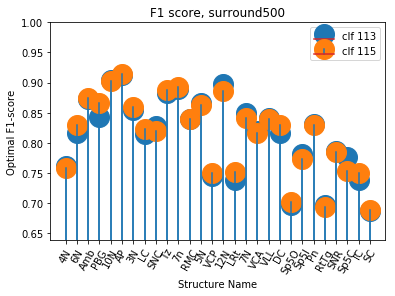

In [179]:
plt.figure();

for classifier_id in classifier_ids:
    for neg_composition_rule in negative_composition_rules:
        
        xticks = range(1, 1 + len(structures_sorted_by_size))
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                                                       [fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size],
         markerfmt='o', markevery=[4,8], label='clf %d' % classifier_id)
        plt.setp(markerLines, markersize=20, alpha=1.)
        plt.xticks(xticks, structures_sorted_by_size, rotation='60');
plt.ylabel('Optimal F1-score');
plt.xlabel('Structure Name');
plt.ylim(np.min([fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                for s in structures_sorted_by_size])-.05, 1);
plt.title('F1 score, %s' % (neg_composition_rule));
plt.legend();
plt.show();

In [175]:
for classifier_id in classifier_ids:
    print {s: fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size}

{'Tz': 0.94383266687173173, 'VCA': 0.87378286270691341, '7n': 0.94552723638180902, 'DC': 0.89994525880420895, '5N': 0.9231055900621119, '3N': 0.92407756367394089, 'Pn': 0.90461385399825889, '10N': 0.94082281199003703, 'LC': 0.91063250402277507, '7N': 0.91344246031746024, 'Amb': 0.95438513990124618, '12N': 0.93725659887494606, 'RMC': 0.91222915901579149, 'Sp5O': 0.82241570735698011, 'Sp5I': 0.85995769114536114, 'Sp5C': 0.86115463420513438, 'VCP': 0.8402046697641592, 'AP': 0.96622796126148502, 'PBG': 0.95254723452017209, 'LRt': 0.84269395525940016, 'IC': 0.82865651128164008, 'VLL': 0.8972403776325345, '4N': 0.96491792726102343, 'SNC': 0.88849878934624704, '6N': 0.96752029981261711, 'SNR': 0.85448481657012454, 'SC': 0.77808313294400544, 'RtTg': 0.80260586319218252}
{'Tz': 0.88417275089716618, 'VCA': 0.81693296385826308, '7n': 0.88876902792760404, 'DC': 0.81353525792711767, '5N': 0.86638381602410375, '3N': 0.85496538483914131, 'Pn': 0.83001916626736938, '10N': 0.90038700992764598, 'LC': 0.

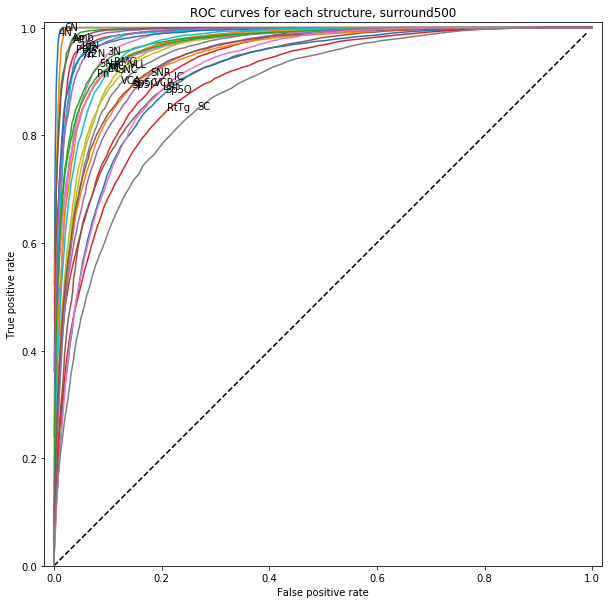

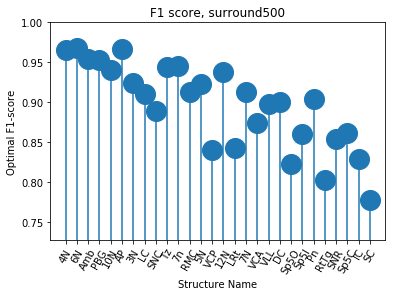

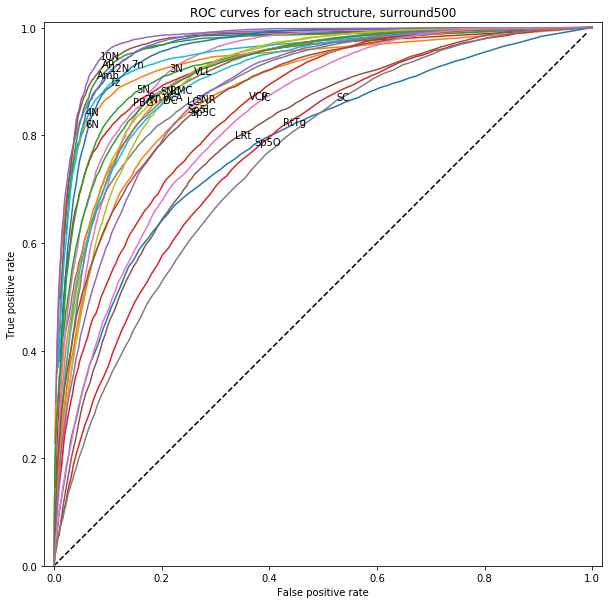

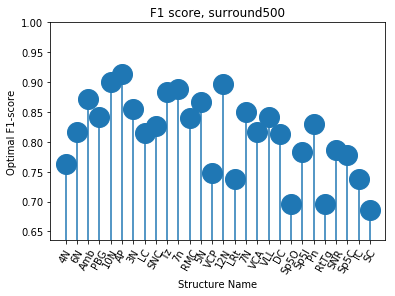

In [176]:
for classifier_id in classifier_ids:
    for neg_composition_rule in negative_composition_rules:

    #     plt.figure(figsize=(15, 10));
        plt.figure(figsize=(10, 10));
        plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

        fopt = {}
        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            plt.plot([fp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)],
                 [tp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)]);

            optimal_th = optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            fopt = f_allthresh[optimal_th]

    #         plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
    #             marker='o', facecolors='none', edgecolors='k')
    #         plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%.2f' % (fopt[s]))
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], s, fontsize=10)

    #     plt.legend();
        plt.ylabel('True positive rate');
        plt.xlabel('False positive rate');
    #     plt.xticks(np.arange(0,1,.1));
        plt.axis('equal');
        plt.ylim([0,1.01]);
        plt.xlim([0,1]);
        plt.title('ROC curves for each structure, %s' % (neg_composition_rule));
        plt.show();

    #     plt.figure();
    #     plt.hist(fopt.values(), bins=np.arange(0.7, 1.0, 0.01));
    #     plt.ylabel("Number of structures");
    #     plt.xlabel("Optimal f1 score");
    #     plt.show();

        plt.figure();
        xticks = range(1, 1 + len(structures_sorted_by_size))
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                                                       [fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size],
         markerfmt='o', markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
        plt.xticks(xticks, structures_sorted_by_size, rotation='60');
        plt.ylabel('Optimal F1-score');
        plt.xlabel('Structure Name');
        plt.ylim(np.min([fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size])-.05, 1);
        plt.title('F1 score, %s' % (neg_composition_rule));
        plt.legend();
        plt.show();

# Compare different classifiers

In [10]:
# fixed_n_pos = None
# fixed_n_neg = None
fixed_n_pos = 1000
fixed_n_neg = 1000

In [11]:
# This specifies what patches has Negative labels.
negative_composition_rules = ['surround200', 'surround500', 'surround1000', 'negative']

In [134]:
classifier_ids = [37, 38, 39, 40, 41, 42]

classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)

acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:
    
    classifier_properties = classifier_settings.loc[classifier_id]    
    svm_id = classifier_properties['svm_id']

    clf_allClasses = {}
    for structure in structures_to_sample:
        clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
        download_from_s3(clf_fp)
        if os.path.exists(clf_fp):
            clf_allClasses[structure] = joblib.load(clf_fp)
        else:
            sys.stderr.write('Classifier for %s is not found.\n' % structure)

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

            features_pos = test_features[structure]
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]
            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

            features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

    #         plot_confusion_matrix(cm, title='%(structure)s vs\nAll surround %(margin_um)d'% {'structure':structure, 'margin_um':margin_um},
    #                               labels=['',''], xlabel='', ylabel='',
    #                              axis=axes[i])

            tp = cm[0,0]
            fn = cm[0,1]
            fp = cm[1,0]
            tn = cm[1,1]

            acc = (tp + tn) / (n_pos + n_neg)
            acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            tp_normalized = tp / n_pos
            fn_normalized = fn / n_pos
            fp_normalized = fp / n_neg
            tn_normalized = tn / n_neg

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized
            fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized
            tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized

    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

rm -rf /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump


Child returned 0
Child returned 1
0.42 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump /shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump && mkdir -p /shared/CSHL_classifiers/setting_38/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump /shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_39/classifiers/sp5_clf_setting_39.dump /shared/CSHL_classifiers/setting_39/classifiers/sp5_clf_setting_39.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_39/classifiers/outerContour_clf_setting_39.dump && mkdir -p /shared/CSHL_classifiers/setting_39/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_39/classifiers/outerContour_clf_setting_39.dump /shared/CSHL_classifiers/setting_39/classifiers/outerContour_clf_setting_39.dump


Child returned 1
0.44 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_40/classifiers/sp5_clf_setting_40.dump /shared/CSHL_classifiers/setting_40/classifiers/sp5_clf_setting_40.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_40/classifiers/outerContour_clf_setting_40.dump && mkdir -p /shared/CSHL_classifiers/setting_40/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_40/classifiers/outerContour_clf_setting_40.dump /shared/CSHL_classifiers/setting_40/classifiers/outerContour_clf_setting_40.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_41/classifiers/sp5_clf_setting_41.dump /shared/CSHL_classifiers/setting_41/classifiers/sp5_clf_setting_41.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_41/classifiers/outerContour_clf_setting_41.dump && mkdir -p /shared/CSHL_classifiers/setting_41/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_41/classifiers/outerContour_clf_setting_41.dump /shared/CSHL_classifiers/setting_41/classifiers/outerContour_clf_setting_41.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_42/classifiers/sp5_clf_setting_42.dump /shared/CSHL_classifiers/setting_42/classifiers/sp5_clf_setting_42.dump


Child returned 1
0.45 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_42/classifiers/outerContour_clf_setting_42.dump && mkdir -p /shared/CSHL_classifiers/setting_42/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_42/classifiers/outerContour_clf_setting_42.dump /shared/CSHL_classifiers/setting_42/classifiers/outerContour_clf_setting_42.dump


Child returned 1
0.47 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

In [135]:
classifier_colors = dict(zip(classifier_ids, np.array(random_colors(len(classifier_ids)))/255.))

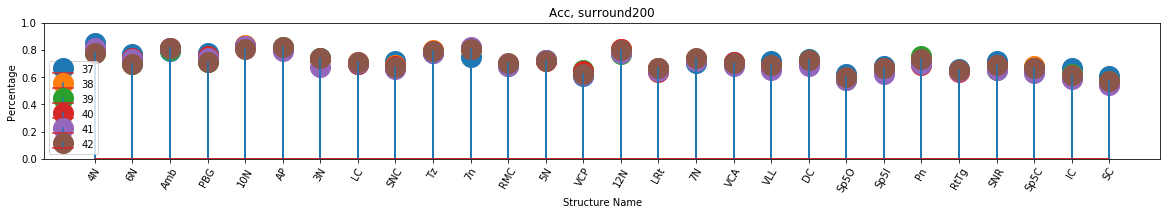

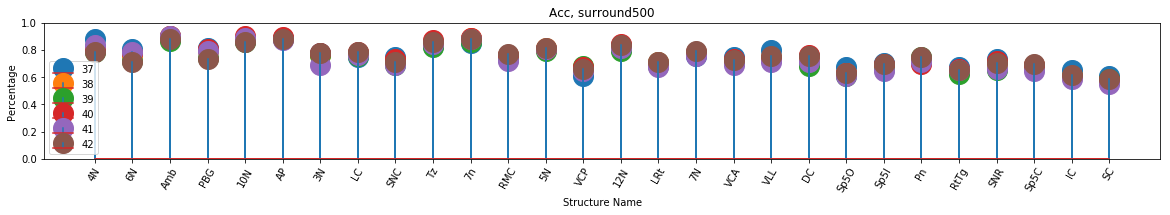

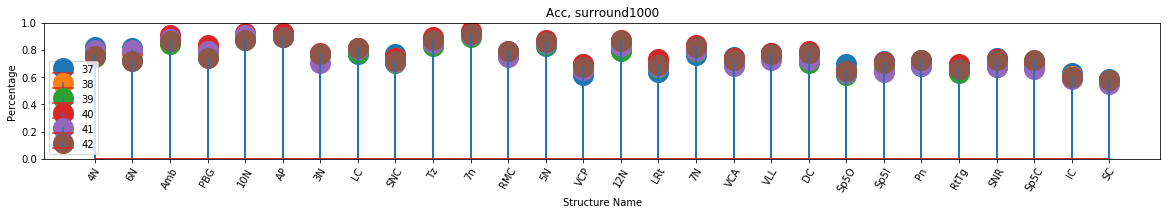

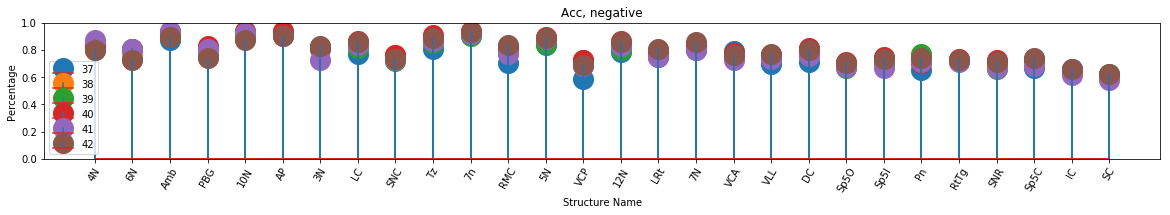

In [196]:
xticks = range(1, 1 + len(structures_sorted_by_size))

for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(20, 2.5));
    
    for classifier_id in classifier_ids:
        
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                 [acc_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                  for s in structures_sorted_by_size],
                 label=classifier_id, markerfmt='o', mc=classifier_colors[classifier_id], markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
    plt.xticks(xticks, structures_sorted_by_size, rotation='60');
    plt.ylabel('Percentage');
    plt.xlabel('Structure Name');
    plt.title('Acc, %s' % (neg_composition_rule));
    plt.ylim([0, 1.]);
    plt.legend();
    plt.show();

In [194]:
# Best classifier for each structure

for neg_composition_rule in negative_composition_rules:
    best_classifier_id_all_structures = [(s, classifier_ids[np.argmax([acc_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
                                                                      for classifier_id in classifier_ids])])
                                         for s in structures_sorted_by_size]
    print neg_composition_rule
    print best_classifier_id_all_structures
    print

surround200
[('4N', 37), ('6N', 37), ('Amb', 40), ('PBG', 37), ('10N', 38), ('AP', 42), ('3N', 42), ('LC', 42), ('SNC', 37), ('Tz', 38), ('7n', 41), ('RMC', 42), ('5N', 41), ('VCP', 39), ('12N', 38), ('LRt', 42), ('7N', 42), ('VCA', 37), ('VLL', 37), ('DC', 37), ('Sp5O', 37), ('Sp5I', 37), ('Pn', 39), ('RtTg', 37), ('SNR', 37), ('Sp5C', 38), ('IC', 37), ('SC', 37)]

surround500
[('4N', 37), ('6N', 37), ('Amb', 41), ('PBG', 37), ('10N', 40), ('AP', 40), ('3N', 37), ('LC', 42), ('SNC', 37), ('Tz', 40), ('7n', 40), ('RMC', 42), ('5N', 42), ('VCP', 39), ('12N', 40), ('LRt', 38), ('7N', 42), ('VCA', 37), ('VLL', 37), ('DC', 40), ('Sp5O', 37), ('Sp5I', 37), ('Pn', 39), ('RtTg', 37), ('SNR', 37), ('Sp5C', 42), ('IC', 37), ('SC', 37)]

surround1000
[('4N', 37), ('6N', 37), ('Amb', 40), ('PBG', 40), ('10N', 40), ('AP', 40), ('3N', 40), ('LC', 40), ('SNC', 37), ('Tz', 40), ('7n', 40), ('RMC', 42), ('5N', 40), ('VCP', 39), ('12N', 40), ('LRt', 40), ('7N', 40), ('VCA', 37), ('VLL', 37), ('DC', 40)

In [195]:
# Average acc over all structures

for neg_composition_rule in negative_composition_rules:
    average_acc_all_classifiers = [(classifier_id, np.mean([acc_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
                                                                      for s in structures_sorted_by_size]))
                                         for classifier_id in classifier_ids]
    print neg_composition_rule
    print sorted(average_acc_all_classifiers, key=lambda x: x[1], reverse=True)
    print

surround200
[(37, 0.7215965419893301), (38, 0.71393268074660388), (42, 0.71265271812798225), (40, 0.71038473523854007), (39, 0.7070876397262521), (41, 0.69704819574960086)]

surround500
[(37, 0.76034453898863574), (40, 0.75830717399404979), (38, 0.753258958858119), (42, 0.75118363767537244), (41, 0.73365595684540441), (39, 0.73167551868391545)]

surround1000
[(40, 0.78013586599152818), (38, 0.76484987292655104), (42, 0.76097536418034561), (37, 0.75953142235952209), (41, 0.74414179337949682), (39, 0.73835068745567611)]

negative
[(40, 0.80275651191758945), (38, 0.79406783534595327), (42, 0.78943299014921819), (39, 0.77405466181903926), (41, 0.77093420195165319), (37, 0.75683688534592186)]



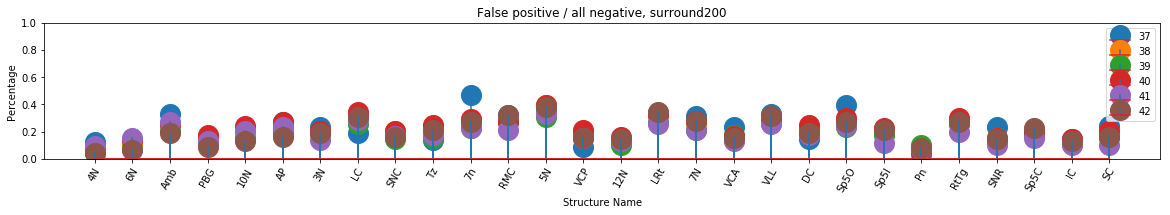

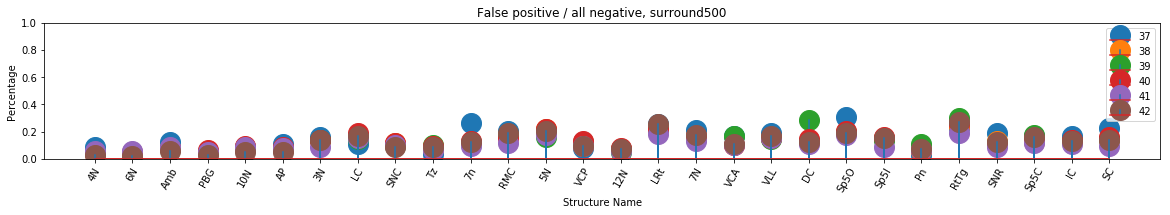

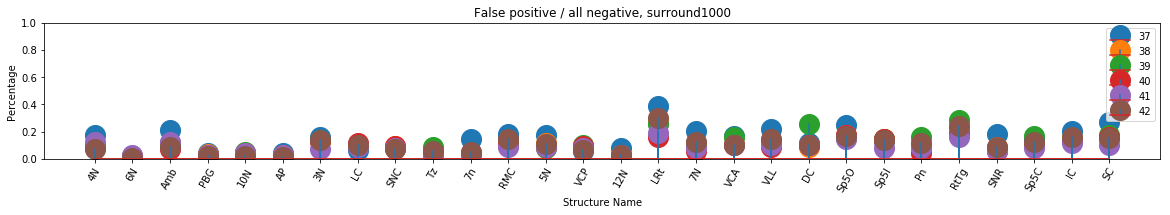

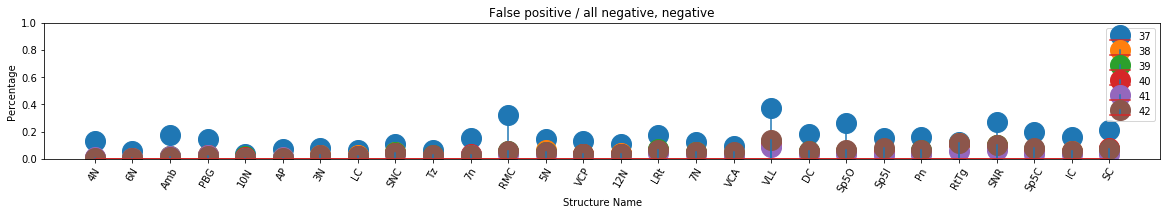

In [137]:
xticks = range(1, 1 + len(structures_sorted_by_size))

for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(20, 2.5));
    for classifier_id in classifier_ids:
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                 [fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                  for s in structures_sorted_by_size],
                 label=classifier_id, markerfmt='o', mc=classifier_colors[classifier_id]);
#         plt.setp(markerLines, color = 'cyan', markersize = 20, markeredgecolor = 'blue', markeredgewidth = 3)
        plt.setp(markerLines, markersize = 20, alpha=1)
    plt.xticks(xticks, structures_sorted_by_size, rotation='60');
    plt.ylabel('Percentage');
    plt.xlabel('Structure Name');
    plt.title('False positive / all negative, %s' % (neg_composition_rule));
    plt.ylim([0, 1.]);
    plt.legend();
    plt.show();

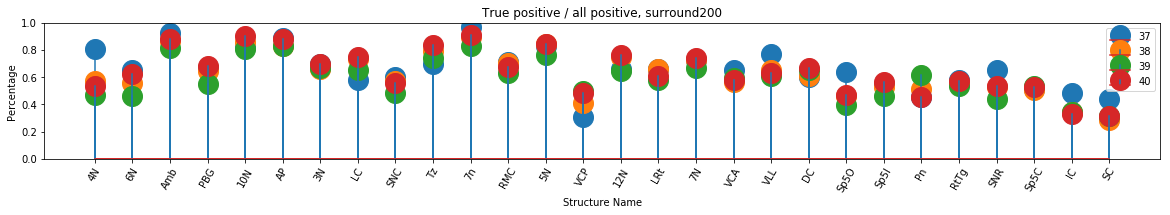

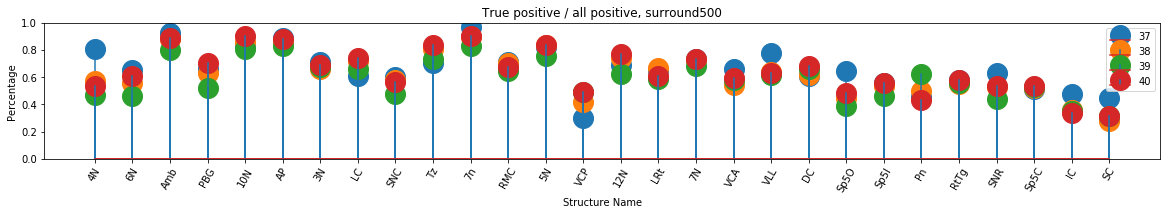

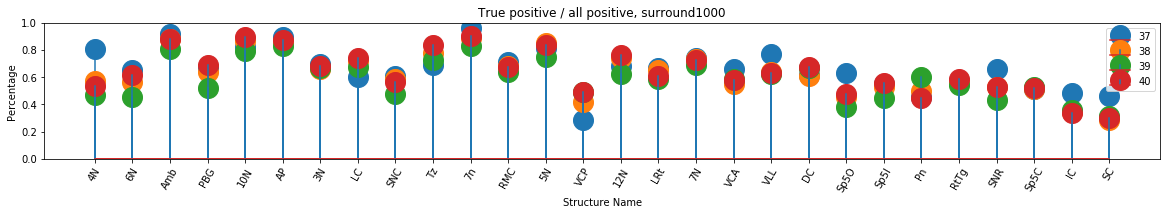

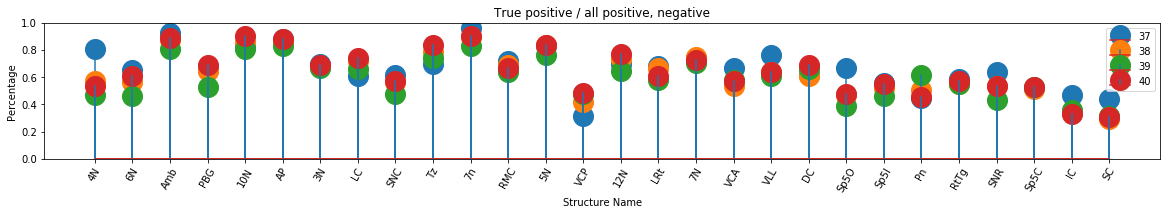

In [132]:
# TP metric only concerns positive, so should be IDENTICAL for different negcomprules.

xticks = range(1, 1 + len(structures_sorted_by_size))

for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(20, 2.5));
    for classifier_id in classifier_ids:
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                 [tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                  for s in structures_sorted_by_size],
                 label=classifier_id, markerfmt='o', mc=classifier_colors[classifier_id]);
#         plt.setp(markerLines, color = 'cyan', markersize = 20, markeredgecolor = 'blue', markeredgewidth = 3)
        plt.setp(markerLines, markersize = 20, alpha=1.)
    plt.xticks(xticks, structures_sorted_by_size, rotation='60');
    plt.ylabel('Percentage');
    plt.xlabel('Structure Name');
    plt.title('True positive / all positive, %s' % (neg_composition_rule));
    plt.ylim([0, 1.]);
    plt.legend();
    plt.show();

# Check one classifier: Load pre-computed svm classifiers

In [21]:
classifier_id = 131

In [22]:
# # setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))
# setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [24]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
    download_from_s3(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

# Generate Evaluation Results

In [13]:
# eval_dir = create_if_not_exists(os.path.join(setting_dir, 'eval'))

# Compute x vs. surround accuracy

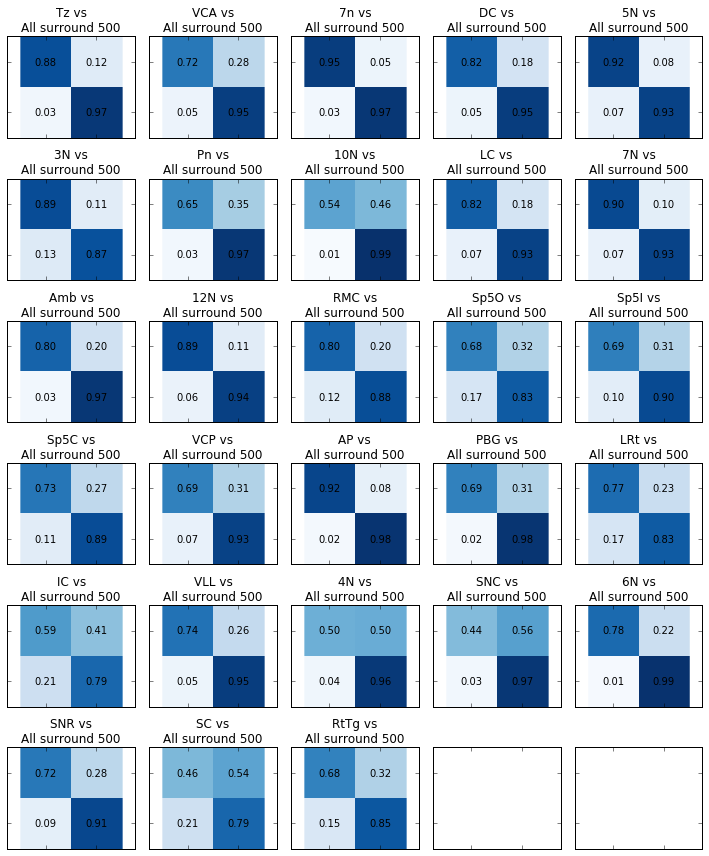

In [25]:
# Compute surround accuracy

margin = 500

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
    n_neg = len(features_neg)

    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]

    if structure not in clf_allClasses:
        sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
        continue
        
    clf = clf_allClasses[structure]

    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)

    plot_confusion_matrix(cm, title='%(structure)s vs\nAll surround %(margin)d'% {'structure':structure, 'margin':margin},
                          labels=['',''], xlabel='', ylabel='',
                         axis=axes[i])

    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[structure] = acc
        
plt.tight_layout()

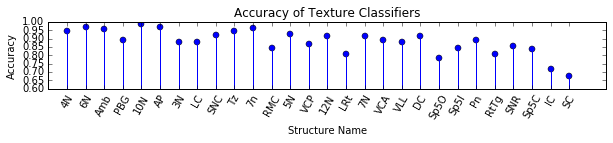

test accuracy: 0.881842468306


In [26]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.6, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

print 'test accuracy:', np.mean(acc_all_structures.values())

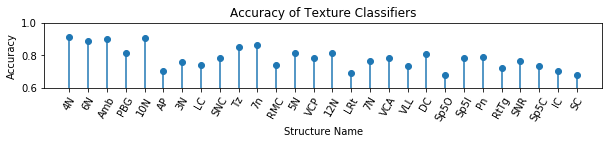

In [39]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.6, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

print 'test accuracy:', np.mean(acc_all_structures.values())

# Compute surround accuracy (margin = 200)

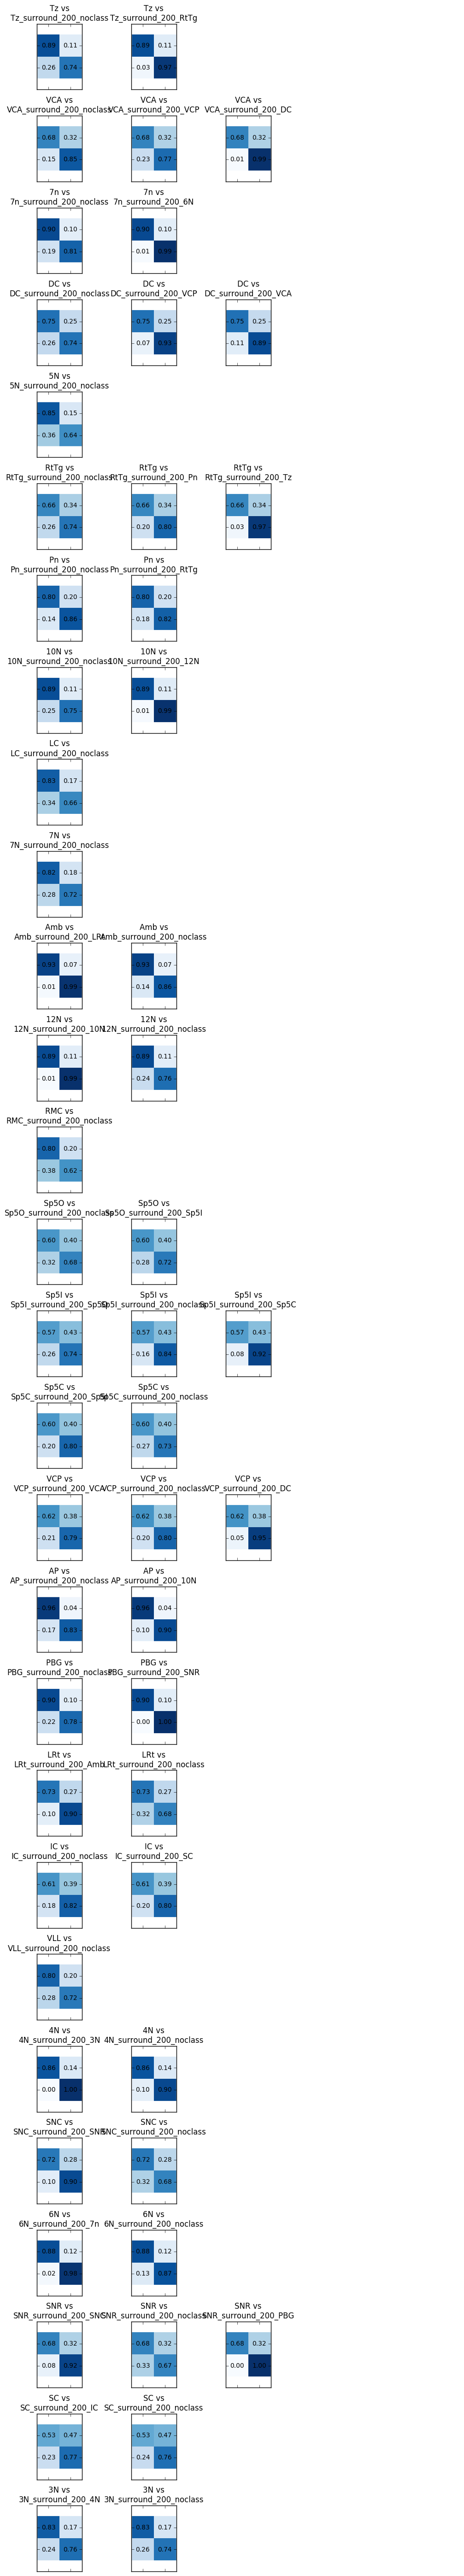

In [31]:
# Compute surround accuracy (margin = 200)

margin = 200
acc_all_pairs = {}
example_number_all_pairs = {}

ncols = 5
nrows = len(structures_found)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
# axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    for j, neg_class in enumerate(neg_classes):

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)

        plot_confusion_matrix(cm, title='%(structure)s vs\n%(neg_class)s'% {'structure':structure, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=False)
        acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
        acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc
        example_number_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = n_pos + n_neg
        
    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [163]:
surround_cm_plot_fp = os.path.join(eval_dir, 'surround_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [33]:
print np.sum([example_number_all_pairs[pair]*acc for pair, acc in acc_all_pairs.iteritems()])/np.sum(example_number_all_pairs.values())

0.77514253233097619

In [20]:
print np.mean(acc_all_pairs.values())

0.781163498179


In [72]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('SC vs SC_surround_200_IC', 0.54535345166832483),
 ('IC vs IC_surround_200_SC', 0.63378344327912872),
 ('10N vs 10N_surround_200_noclass', 0.66050820739068417),
 ('SNC vs SNC_surround_200_noclass', 0.6633200091275756),
 ('RtTg vs RtTg_surround_200_noclass', 0.6714797206147668),
 ('6N vs 6N_surround_200_noclass', 0.68985533506809538),
 ('VCP vs VCP_surround_200_noclass', 0.69551525152803007),
 ('SNR vs SNR_surround_200_noclass', 0.69812509104994369),
 ('LC vs LC_surround_200_noclass', 0.69853481782094007),
 ('Tz vs Tz_surround_200_noclass', 0.70507607073460576),
 ('SC vs SC_surround_200_noclass', 0.71317376942676081),
 ('7N vs 7N_surround_200_noclass', 0.71696350213779547),
 ('12N vs 12N_surround_200_noclass', 0.72143003058763044),
 ('VCP vs VCP_surround_200_VCA', 0.73092031183557071),
 ('Pn vs Pn_surround_200_RtTg', 0.73416013205951769),
 ('Sp5C vs Sp5C_surround_200_noclass', 0.73950306731435578),
 ('RtTg vs RtTg_surround_200_Pn', 0.74218217411311727),
 ('VLL vs VLL_surround_200_nocl

# Compute surround accuracy for different margins

In [21]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in margins_to_sample:

    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, structure in enumerate(structures_found):

        features_pos = test_features[structure]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]
        
        neg_classes = list(set(neg_classes) & set(labels_found))

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]

            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc

    acc_all_margins[margin] = acc_all_pairs

margin = 200
margin = 500


In [22]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

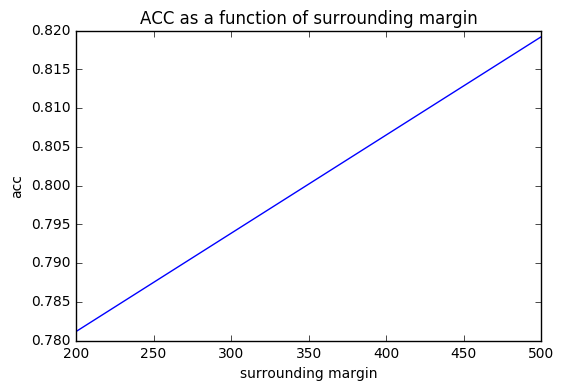

In [23]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute x vs. all negative accuracy

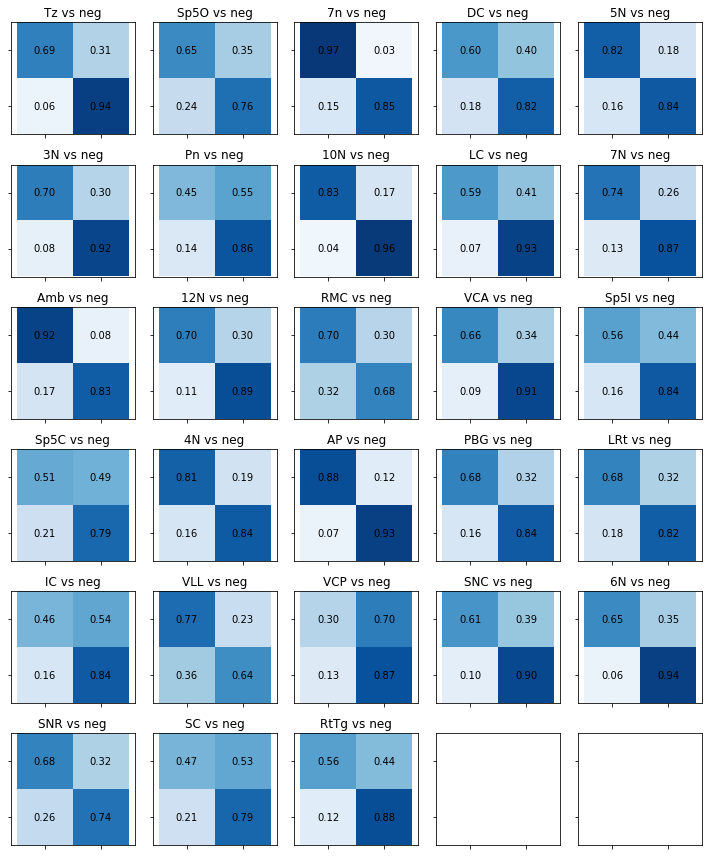

In [53]:
# Compute testing accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features[structure + '_negative']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs neg'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[structure] = acc

plt.tight_layout()

# single_vs_negative_cm_plot_fp = os.path.join(eval_dir, 'single_vs_negative_cm_setting_%d_testset_%d.png' % (setting, dataset))
# fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

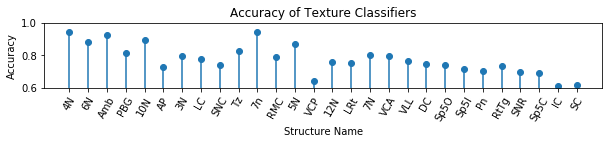

In [43]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.6, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

print 'test accuracy:', np.mean(acc_all_structures.values())

# Compute X with all surround

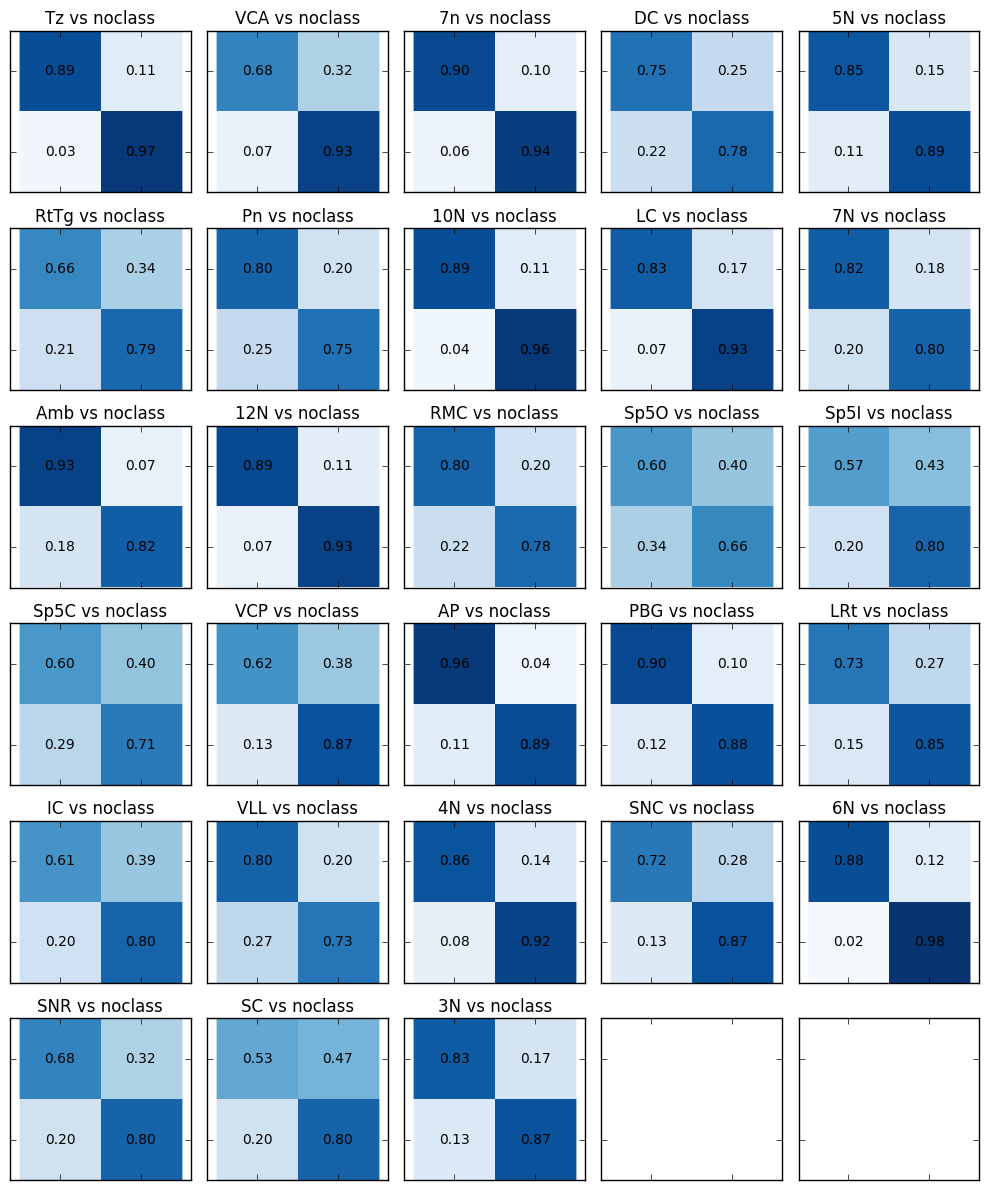

In [15]:
# Compute x vs. noclass accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features['noclass']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs noclass'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()


print 'test accuracy:', np.mean(acc_all_structures.values())

# single_vs_noclass_cm_plot_fp = os.path.join(eval_dir, 'single_vs_noclass_cm_setting_%d_testset_%d.png' % (setting, dataset))
# fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute pairwise accuracy

In [76]:
# Compute pairwise accuracy

n_structures = len(structures_found)
pairwise_cm = np.zeros((n_structures, n_structures))

# for i, label in enumerate(structures):
# axes_id = 0
for i, structure in enumerate(structures_found):
    
#     print i, structure
    
    features_pos = test_features[structure]
    n_pos = len(features_pos)
        
    for j, structure2 in enumerate(structures_found):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
#         print 'comparing with', j, structure2
        
        features_neg = test_features[structure2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

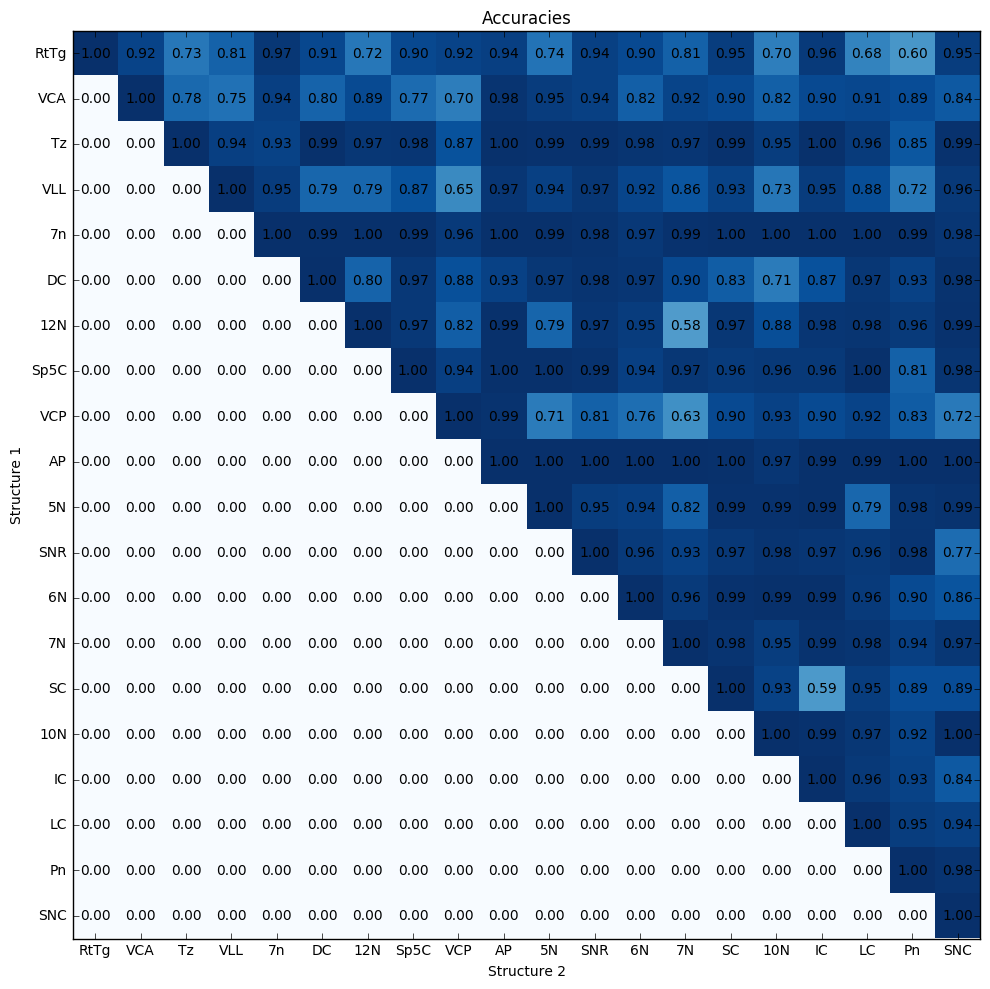

In [77]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=structures_found,
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [78]:
pariwise_cm_plot_fp = os.path.join(eval_dir, 'pairwise_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')